In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from model import RNN

### Preparation ####

# set random seed
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

# set precision and device
torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
print(device)

### load dataset ###


def load_data(mode='train'):
    data = np.loadtxt('./data_{}.txt'.format(mode), dtype='str')
    inputs = data[:,:2]
    labels = data[:,2]

    def strs2mat(strings):
        num = strings.shape[0]
        mat = []
        for i in range(num):
            mat.append([*strings[i]])
        return mat

    inputs_ = np.transpose(np.array([strs2mat(inputs[:,0]), strs2mat(inputs[:,1])]), (1,2,0)).astype('float')
    labels_ = np.array(strs2mat(labels))[:,:,np.newaxis].astype('float')

    return inputs_, labels_

inputs_train, labels_train = load_data(mode='train')
inputs_test, labels_test = load_data(mode='test')

inputs_train = torch.tensor(inputs_train, dtype=torch.float, requires_grad=True).to(device)
labels_train = torch.tensor(labels_train, dtype=torch.float, requires_grad=True).to(device)
inputs_test = torch.tensor(inputs_test, dtype=torch.float, requires_grad=True).to(device)
labels_test = torch.tensor(labels_test, dtype=torch.float, requires_grad=True).to(device)

def l1(model):
    l1_reg = torch.tensor(0.).to(device)
    for param in model.parameters():
        l1_reg += torch.sum(torch.abs(param))
    return l1_reg
    

model = RNN(hidden_dim=2, device=device).to(device)

cpu


In [2]:
### Training ###

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0)
steps = 3000
log = 200
lamb = 0e-4

for step in range(steps):
    
    optimizer.zero_grad()
    
    pred_train = model(inputs_train)
    loss_train = torch.mean((pred_train-labels_train)**2)
    acc_train = 1-loss_train

    pred_test = model(inputs_test)
    loss_test = torch.mean((pred_test-labels_test)**2)
    acc_test = 1-loss_test
    
    reg = l1(model)
    loss = loss_train + lamb * reg
    
    loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | train loss: %.2e | test loss %.2e | train acc: %.2e | test acc: %.2e | reg: %.2e "%(step, loss_train.cpu().detach().numpy(), loss_test.cpu().detach().numpy(), acc_train.cpu().detach().numpy(), acc_test.cpu().detach().numpy(), reg.cpu().detach().numpy()))
    
torch.save(model.state_dict(), './model')

step = 0 | train loss: 1.80e+00 | test loss 1.80e+00 | train acc: -8.05e-01 | test acc: -8.03e-01 | reg: 6.06e+00 
step = 200 | train loss: 1.27e-01 | test loss 1.31e-01 | train acc: 8.73e-01 | test acc: 8.69e-01 | reg: 7.45e+00 
step = 400 | train loss: 3.19e-02 | test loss 3.39e-02 | train acc: 9.68e-01 | test acc: 9.66e-01 | reg: 1.26e+01 
step = 600 | train loss: 6.58e-03 | test loss 6.46e-03 | train acc: 9.93e-01 | test acc: 9.94e-01 | reg: 1.57e+01 
step = 800 | train loss: 2.95e-03 | test loss 2.77e-03 | train acc: 9.97e-01 | test acc: 9.97e-01 | reg: 1.70e+01 
step = 1000 | train loss: 1.78e-03 | test loss 1.65e-03 | train acc: 9.98e-01 | test acc: 9.98e-01 | reg: 1.78e+01 
step = 1200 | train loss: 1.22e-03 | test loss 1.13e-03 | train acc: 9.99e-01 | test acc: 9.99e-01 | reg: 1.84e+01 
step = 1400 | train loss: 9.01e-04 | test loss 8.26e-04 | train acc: 9.99e-01 | test acc: 9.99e-01 | reg: 1.89e+01 
step = 1600 | train loss: 6.94e-04 | test loss 6.33e-04 | train acc: 9.99e-01

In [3]:
model.eval()

RNN(
  (Wh): Linear(in_features=2, out_features=2, bias=True)
  (Wx): Linear(in_features=2, out_features=2, bias=True)
  (Wy): Linear(in_features=2, out_features=1, bias=True)
  (act): Sigmoid()
)

In [4]:
inputs=inputs_train
labels = labels_train
seq_length=inputs_train.shape[1]

In [5]:
batch_size = inputs.shape[0]
hidden = torch.zeros(batch_size, model.hidden_dim).to(device)
hiddens = []

for i in range(seq_length):
    hidden = model.act(model.Wh(hidden) + model.Wx(inputs[:,i,:]))
    out = model.Wy(hidden)
    hiddens.append(hidden.clone().cpu().detach().numpy())

In [6]:
hiddens = np.transpose(np.array(hiddens), (1,0,2))

In [7]:
hiddens.shape

(819, 1, 2)

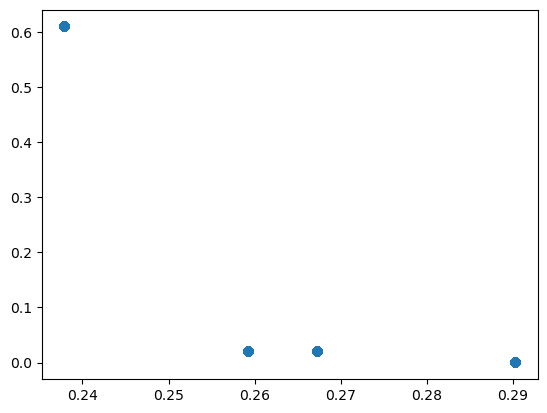

In [8]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 

x = hiddens[:,:,0].reshape(-1,)
y = hiddens[:,:,1].reshape(-1,)

plt.scatter(x, y)

In [9]:
# clustering

from sklearn.cluster import KMeans
X = np.transpose(np.array([x,y]))
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
vectorlist = kmeans.cluster_centers_

In [10]:
vectorlist

array([[2.3790045e-01, 6.0962266e-01],
       [2.6729748e-01, 2.0262957e-02],
       [2.9030189e-01, 2.9169023e-04],
       [2.5927007e-01, 2.1560565e-02]], dtype=float32)

In [11]:
# find parallelogram

# Tries to interpret 2^n vectors as n bits, defining an n-dimensional parallelogram
# Max Tegmark Aug 25 2023

import time
import numpy as np
import scipy, itertools


def bitstring2int(s): return int(s,2)

def int2bitstring(n,i): 
    s = bin(i)[2:]
    return "".join(["0" for j in range(n-len(s))])+s

def str2int(lst): return list(map(int,lst))

# Computes all 2^n bitstrings f length n:
def allstrings(n): [int2bitstring(n,i) for i in range(2**n)]

# Computes B-matrix whose rows are all 2^n bit strings of length n:
def Bmatrix(n): 
    return np.array([str2int(list(int2bitstring(n,i))) for i in range(2**n)])

def list2nN(lst):
    N = len(lst)
    n = int(np.log(N)/np.log(2))
    if 2**n != N: 
        print("List length not power of 2: ",f,N,n)
        exit()
    return n,N                

# Input:   a list of 2^n vectors
# Output:  fitting error to model where these vectors form an n-dimensional parallelogram in canonical order
# Demo:  vectorlist =[[10,20],[10,22],[11,21],[11,23]]
def parallelogramFit(vectorlist):
    n,N = list2nN(vectorlist)
    A = np.array(vectorlist)
    A = A - A[0] # WLOG 1st point is at the origin
    B = Bmatrix(n)
    BtB = B.T @ B
    BBinv = np.linalg.inv(BtB)
    X = BBinv @ B.T @ A
    E = A - B @ X # Fitting error
    error = np.trace(E.T @ E)/np.trace(A.T @ A) # Between & 1, where 0 = perfect
    return error


# Input:   a list of 2^n vectors
# Output:  a list of 2^b bitstring of length n, labeling these vectors
# Demo:  vectorlist =[[10,20],[10,22],[11,21],[11,23]]
# Calls parallelogramFit for all permutations of the vectors and returns best fit.

# Computes inverse permutation:
def invperm(perm):
    n = len(perm)
    p = [0 for i in range(n)]
    for i in range(n): p[perm[i]]=i
    return p
# Demo: invperm([1,2,3,0])

def vecs2bits(vectorlist):
    n,N = list2nN(vectorlist)
    perms = list(itertools.permutations(range(N)))
    besterror = 666.
    for perm in itertools.permutations(range(N)):
        A = [vectorlist[i] for i in perm]
        error = parallelogramFit(A)
        #print(perm,error)
        if error < besterror:
            error = besterror
            bestperm = perm
    B = Bmatrix(n)
    p = invperm(bestperm)
    bestB = np.array([B[p[i]] for i in range(N)]).astype(int)
    return bestB,besterror



In [12]:
cluster_bits = 1 - vecs2bits(vectorlist.tolist())[0]

In [13]:
x = np.arange(2**4)

rs = []

for i in range(4):
    x, r = np.divmod(x, 2)
    rs.append(r)
    
rs = np.transpose(np.array(rs))

In [14]:
rs

array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 1, 1, 0],
       [1, 1, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 1],
       [0, 1, 0, 1],
       [1, 1, 0, 1],
       [0, 0, 1, 1],
       [1, 0, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1]])

In [15]:
cluster_bits

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [16]:
vectorlist

array([[2.3790045e-01, 6.0962266e-01],
       [2.6729748e-01, 2.0262957e-02],
       [2.9030189e-01, 2.9169023e-04],
       [2.5927007e-01, 2.1560565e-02]], dtype=float32)

In [17]:
hidden = vectorlist[rs[:,0]*2 + rs[:,1]]
print(hidden)
x = rs[:,[2,3]]
print(x)

hidden = torch.tensor(hidden, dtype=torch.float)
x = torch.tensor(x, dtype=torch.float)
print(x.shape)
out = model.Wy(hidden)

hidden = model.act(model.Wh(hidden) + model.Wx(x))

out_bit = np.round(out[:,0].detach().numpy()).astype(int)

hidden_next_bit = cluster_bits[np.argmin(np.linalg.norm(hidden.detach().numpy()[np.newaxis,:,:] - vectorlist[:,np.newaxis,:], axis=2), axis=0)]

[[2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]
 [2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]
 [2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]
 [2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]]
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]
torch.Size([16, 2])


In [18]:
print(hidden.shape)

torch.Size([16, 2])


In [19]:
x.shape

torch.Size([16, 2])

In [21]:
hidden = vectorlist[rs[:,0]*2 + rs[:,1]]
print(hidden)
x = rs[:,[2,3]]
print(x)

hidden = torch.tensor(hidden, dtype=torch.float)
x = torch.tensor(x, dtype=torch.float)
print(x.shape)
out = model.Wy(hidden)

hidden = model.act(model.Wh(hidden) + model.Wx(x))

out_bit = np.round(out[:,0].detach().numpy()).astype(int)

hidden_next_bit = cluster_bits[np.argmin(np.linalg.norm(hidden.detach().numpy()[np.newaxis,:,:] - vectorlist[:,np.newaxis,:], axis=2), axis=0)]

[[2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]
 [2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]
 [2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]
 [2.3790045e-01 6.0962266e-01]
 [2.9030189e-01 2.9169023e-04]
 [2.6729748e-01 2.0262957e-02]
 [2.5927007e-01 2.1560565e-02]]
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]
torch.Size([16, 2])


In [22]:
hidden2

array([[2.3790045e-01, 6.0962266e-01],
       [2.9030189e-01, 2.9169023e-04],
       [2.6729748e-01, 2.0262957e-02],
       [2.5927007e-01, 2.1560565e-02],
       [2.3790045e-01, 6.0962266e-01],
       [2.9030189e-01, 2.9169023e-04],
       [2.6729748e-01, 2.0262957e-02],
       [2.5927007e-01, 2.1560565e-02],
       [2.3790045e-01, 6.0962266e-01],
       [2.9030189e-01, 2.9169023e-04],
       [2.6729748e-01, 2.0262957e-02],
       [2.5927007e-01, 2.1560565e-02],
       [2.3790045e-01, 6.0962266e-01],
       [2.9030189e-01, 2.9169023e-04],
       [2.6729748e-01, 2.0262957e-02],
       [2.5927007e-01, 2.1560565e-02]], dtype=float32)

In [23]:
hidden

tensor([[1.9770e-01, 1.8057e-04],
        [2.5019e-01, 2.6715e-04],
        [2.5113e-01, 2.6545e-04],
        [2.5205e-01, 2.6586e-04],
        [1.8017e-01, 1.2637e-02],
        [2.2934e-01, 1.8586e-02],
        [2.3022e-01, 1.8469e-02],
        [2.3109e-01, 1.8498e-02],
        [1.7413e-01, 1.3453e-02],
        [2.2210e-01, 1.9778e-02],
        [2.2297e-01, 1.9654e-02],
        [2.2382e-01, 1.9685e-02],
        [1.5828e-01, 4.9146e-01],
        [2.0296e-01, 5.8846e-01],
        [2.0377e-01, 5.8691e-01],
        [2.0456e-01, 5.8729e-01]], grad_fn=<SigmoidBackward0>)

In [24]:
# (hidden_current, x_current) => hidden_next; rs => hidden_next_bit
# hidden_current = rs[:4, :2] => out_bit = out_bit[:4]

In [25]:
# three symbolic functions to be learned
# out from h[0], h[1]
# h[0] from last h[0], h[1], current x[0], x[1]
# h[1] from last h[0], h[1], current x[0], x[1]


# Tools for symbolic regression of boolean functions
# Max Tegmark Aug 24-25 2023

import time
from math import log

def bitstring2int(s): return int(s,2)

def int2bitstring(n,i): 
    s = bin(i)[2:]
    return "".join(["0" for j in range(n-len(s))])+s

# A boolean function f is defined as a string f of length 2^n, say "00010001"
# The argument list is defined as a string x length n ,say "011"
# Returns char "0" or "1"
def booleval(f,x):
    n = len(x)
    if len(f) != 2**n: 
        print("String length mismatch error: ",n,2**n,len(s))
        exit()
    i = bitstring2int(x)
    return f[i]
# DEMO: booleval("11111111","111")

# Flip the ith bit in the bitstring n
def flip_bit(x,i):
    s = list(x)
    s[i] = str(1-int(s[i]))
    return "".join(s)
# DEMO: flip_bit("11111111",2)

def f2nN(f):
    N = len(f)
    n = int(log(N)/log(2))
    if 2**n != N: 
        print("String length not power of 2: ",f,N,n)
        exit()
    return n,N

def bitsum(s): return sum([int(c) for c in s])

def find_variables_used(f):
    # Returns e.g. "101" if function f depends on x_0 & x_2 but not x_1
    n,N = f2nN(f)
    s = ["0" for i in range(n)]
    for i in range(N):
        x = int2bitstring(n,i)
        for k in range(n):
            if booleval(f,x) != booleval(f,flip_bit(x,k)): s[k] = "1"
    return "".join(s)
# DEMO: find_variables_used("01100110") # x[1] XOR x[2]

# Return the function f restricted to the only variables it depends on:
def subfunc(f):
    used = find_variables_used(f)
    n = len(used)
    vars = [i for i in range(n) if used[i]=="1"]
    n1 = len(vars)
    N1 = 2**n1
    f1 = ["0" for i in range(N1)]
    for i in range(N1):
        x1 = int2bitstring(n1,i)
        x  = ["0" for i in range(n)]
        for k in range(n1): x[vars[k]] = x1[k]
        f1[i] = booleval(f,"".join(x))
    return f1,vars
# DEMO: subfunc("01100110") # x[1] XOR x[2]

def parallelogram():
    return

def symmetricQ(f):
    # Check if f is fully symmetric under all permutations of its variables, thus depending only on variable sum
    # If so, returns string giving value taken for each bit sum, otherwise returns "".
    # 2**(n+1) out of the 2**N functions are symmetric.
    n,N = f2nN(f)
    s = ["-" for i in range(n+1)]
    for i in range(N):
        x = int2bitstring(n,i)
        k = bitsum(x)
        c = booleval(f,x) 
        if s[k] != c:
            if s[k] == "-": s[k] = c
            else: return ""
    return "".join(s)

# Write x as boolean condition"
def x2dnf(x,varnames):
    n = len(x)
    return " and ".join([["not ",""][int(x[i])]+varnames[i] for i in range(n)])
# Demo: x2dnf("110","abc") 
# returns "a and b and not c"

# Write f in disjunctive normal form:
def f2dnf(f,varnames):
    n,N = f2nN(f)
    return " or ".join(["("+x2dnf(int2bitstring(n,i),varnames)+")" for i in range(N) if f[i]=="1"])
# Demo: f2dnf("01100110","abc") 
# returns "a and b and not c"

# Checks if string of type "010101010":
def parityQ(s):
    x = [int(c) for c in s]
    if x[0] != 0: return False
    for i in range(len(x)-1):
        if x[i]+x[i+1] != 1: return False
    return True
# DEMO: parityQ("01010")
    
# Checks if string is sorted, like e.g. "0000111":
def sortedQ(s):
    for i in range(len(s)-1):
        if s[i]>s[i+1]: return False
    return True

# Returns 4 if s="0000111", returns -1 if not step function
def stepupQ(s):
    if not sortedQ(s): return -1
    for i in range(len(s)): 
        if s[i]=="1": return i-1
    return -1

# Returns 4 if s="1111000", returns -1 if not step function
def stepdownQ(s):
    if not sortedQ("".join(reversed(s))): return -1
    for i in range(len(s)): 
        if s[i]=="0": return i-1
    return -1

def symmfunc(s,varsum):
    return " or ".join([varsum+"=="+str(i) for i in range(len(s)) if s[i]=="1"])
# Demo: symmfunc("1001","abc") 
# returns "a+b+c==0 or a+b+c==3"

# Given a string s specifying how function depends on bit sum, return the formula:
def symmetric_formula(s,varnames):
    if len(varnames)==1 and s=="10": return "not "+varnames[0]
    if parityQ(s): return " xor ".join(varnames) # f is xor of all variables
    varsum = "+".join(varnames)
    i = stepupQ(s) 
    if i >= 0: return varsum+">"+str(i)
    i = stepdownQ(s) 
    if i >= 0: return varsum+"<"+str(i+1)
    return symmfunc(s,varsum)

def formula(f):
    f1,vars = subfunc(f)
    varnames = [chr(97+i) for i in vars]
    if varnames == []: return str(bool(int(f[0]))) # Function is a constant
    formula1 = f2dnf(f1,varnames)
    s = symmetricQ(f1)
    if s == "": return formula1
    formula2 = symmetric_formula(s,varnames)
    if len(formula2)<len(formula1): formula1 = formula2 # Pick shortest formula
    return formula1


#def shortest_formula(f):
    

def demo1():
    n = 3
    N = 2**n
    for i in range(2**N):
        f = int2bitstring(N,i)
        print(f+": "+formula(f))
        #time.sleep(.5)
    return

def demo2():
    print(formula("00000000")) # False
    print(formula("11111111")) # True
    print(formula("00001111")) # a
    print(formula("01100110")) # b xor c
    print(formula("01101001")) # a xor b xor c
    print(formula("01111111")) # a+b+c==1 or a+b+c==2 or a+b+c==3 <=========
    print(formula("00010111")) # a+b+c==2 or a+b+c==3
    print(formula("00000001")) # a+b+c==3
    print(formula("11101000")) # a+b+c==0 or a+b+c==1  FAILS
    print(formula("10000001")) # a+b+c==0 or a+b+c==3





In [26]:
# (hidden_current, x_current) => hidden_next; rs => hidden_next_bit
# hidden_current = rs[:4, :2] => out_bit = out_bit[:4]
str_arr = np.zeros(16,dtype=int)
indices = np.sum(rs * 2**np.array([3,2,1,0]), axis=1)
str_arr[indices] = hidden_next_bit[:,0]
string = ""
for bit in list(str_arr):
    string += str(bit)
next_a_formula = formula(string)

In [27]:
next_a_formula

'c+d<2'

In [28]:
str_arr = np.zeros(16,dtype=int)
indices = np.sum(rs * 2**np.array([3,2,1,0]), axis=1)
str_arr[indices] = hidden_next_bit[:,1]
string = ""
for bit in list(str_arr):
    string += str(bit)
next_b_formula = formula(string)

In [29]:
next_b_formula

'c+d<2'

In [30]:
# output bit
str_arr = np.zeros(4,dtype=int)
indices = np.sum(rs[:4,:2] * 2**np.array([1,0]), axis=1)
str_arr[indices] = out_bit[:4]
string = ""
for bit in list(str_arr):
    string += str(bit)
out_formula = formula(string)

In [31]:
out_formula

'a+b<1'

In [32]:
print(next_a_formula)
print(next_b_formula)
print(out_formula)

c+d<2
c+d<2
a+b<1


In [33]:
import re
import numpy as np
#This is Vedang's version of the code to go from text to python
def convert_logical_to_python(logical_expression):
    """
    Converts a logical expression into its equivalent Python representation using NumPy bitwise operators.

    Args:
        logical_expression (str): The logical expression to be converted.

    Returns:
        str: The Python representation of the logical expression.
    """
    
    #This is the case we have a constraint
    if "<" in logical_expression or ">" in logical_expression:
        return logical_expression
    
    def extract_elements(logical_expression):
        """
        Extracts elements enclosed in parentheses from a logical expression.

        Args:
            logical_expression (str): The logical expression.

        Returns:
            list: A list of elements inside parentheses.
        """
        inside_elements = re.findall(r'\((.*?)\)', logical_expression)
        return inside_elements

    def apply_not(expression):
        """
        Applies the NOT operation to a given expression.

        Args:
            expression (str): The expression to be negated.

        Returns:
            str: The negated expression.
        """
        return f'1 - {expression}'

    def convert_logic_operators(formula_split):
        """
        Converts logical operators in a formula split into their equivalent Python representation.

        Args:
            formula_split (list): The split components of a logical formula.

        Returns:
            list: The list of converted components.
        """

        operators_mapping = {'or': 'np.bitwise_or', 'and': 'np.bitwise_and', 'xor': 'np.bitwise_xor', 'not': apply_not}

        formula_np = []
        skip_next = False

        for i, sub in enumerate(formula_split):
            if skip_next:
                skip_next = False
                continue

            mapped_sub = operators_mapping.get(sub, sub)
            if callable(mapped_sub):
                mapped_sub = mapped_sub(formula_split[i + 1])
                skip_next = True

            formula_np.append(mapped_sub)
        return formula_np

    def build_expression(formula_np):
        """
        Builds a Python expression from a list of converted components.

        Args:
            formula_np (list): The list of converted components.

        Returns:
            str: The Python expression.
        """

        expression_str = ""
        i = 0

        while i < len(formula_np):
            sub = formula_np[i]

            if sub in {'np.bitwise_and', 'np.bitwise_or', 'np.bitwise_xor'}:
                expression_str = f'{sub}({expression_str},{formula_np[i+1]})'
                i += 2
            elif callable(sub):
                expression_str = f'{sub}({formula_np[i+1]})'
                i += 2
            else:
                expression_str += sub
                i += 1

        return expression_str

    inside_elements = extract_elements(logical_expression)
    to_or = [build_expression(convert_logic_operators(element.split())) for element in inside_elements]
    
    #If there are no subexpressions in () - we don't have to OR all of them ()
    if len(inside_elements) == 0:
        return build_expression(convert_logic_operators(logical_expression.split()))

    def or_everything(expressions):
        """
        Combines multiple expressions using the NumPy bitwise OR operation.

        Args:
            expressions (list): List of expressions to be combined.

        Returns:
            str: The final combined expression.
        """
        if len(expressions) < 2:
            return expressions[0]

        final_expr = f"np.bitwise_or({expressions[0]}, {expressions[1]})"
        for i in range(2, len(expressions)):
            final_expr = f"np.bitwise_or({final_expr}, {expressions[i]})"
        return final_expr
    return or_everything(to_or)


In [34]:
next_a_formula_str = convert_logical_to_python(next_a_formula)
next_b_formula_str = convert_logical_to_python(next_b_formula)
out_formula_str = convert_logical_to_python(out_formula)

In [35]:
print(next_a_formula_str)
print(next_b_formula_str)
print(out_formula_str)

c+d<2
c+d<2
a+b<1


In [36]:
xs = inputs.detach().numpy().astype(int)
out_labels = labels.detach().numpy().astype(int)

In [37]:
# xs are inputs, with shape (batch size, sequence length, 2)
a = np.zeros(xs.shape[0],).astype(int)
b = np.zeros(xs.shape[0],).astype(int)
outs = []

for i in range(xs.shape[1]):
    c = xs[:,i,0]
    d = xs[:,i,1]

    exec('a = ' + next_a_formula_str)
    exec('b = ' + next_b_formula_str)
    exec('out = ' + out_formula_str)
    outs.append(a)

outs = np.transpose(np.array(outs))

In [38]:
#Hack/Error
#This is supposed to be 1-out_labels[:,:,0] but somehow that isnt working
num_error = np.sum((out_labels[:,:,0] == outs))
num_error

0